In [1]:
from iris import RawDataset, DiffractionDataset
import numpy as n
from os import listdir
from os.path import join, isdir
from scipy.misc import imread
from skimage.feature import register_translation
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib notebook
RESOLUTION = (2048, 2048)
TEST_PATH = 'C:\\Diffraction data\\data_for_banff\\M43 20160825 to 20160916\\201608262728 scans\\Scans_02-09_01-02first3_25steps'
OUTPUT_PATH = 'sample4_many_scans.hdf5'

In [2]:
def shift(src, shifts):
    """ Shift an image"""
    non = lambda s: s if s < 0 else None
    mom = lambda s: max(0,s)

    oy, ox = shifts

    shifted = n.zeros_like(src)
    shifted[mom(oy):non(oy), mom(ox):non(ox)] = src[mom(-oy):non(-oy), mom(-ox):non(-ox)]
    return shifted

In [3]:
class SRawDataset(RawDataset):

    resolution = RESOLUTION
    fluence = 0
    current = 0
    exposure = 0
    energy = 0
    acquisition_date = '0.0.0.0'
    
    @property
    def time_points_str(self):
        directory = join(self.raw_directory, listdir(self.raw_directory)[0])
        files = filter(lambda p: p.endswith('.png'), listdir(directory))
        indices = map(lambda p: str(p).split('_')[0], files)
        return list(filter(lambda i: int(i)%2 == 1, indices))
    
    @property
    def time_points(self):
        return list(map(int, self.time_points_str))
    
    @property
    def nscans(self):   
        potentials = [join(self.raw_directory, p) for p in listdir(self.raw_directory) if isdir(join(self.raw_directory, p))]
        return list(range(len(potentials)))

    def process(self, filename, callback = print):
        """
        Processes raw data into something useable by iris.
        
        Parameters
        ----------
        filename : str {*.hdf5}
            Filename for the DiffractionDataset object
        compression : str, optional

        callback : callable or None, optional
            Callable with one argument executed at the end of each time-delay processing.
            Argument will be the progress as an integer between 0 and 100.
        
        Returns
        -------
        path
        """
        
        # Prepare compression kwargs
        ckwargs = {'compression' : 'lzf', 'chunks' : True, 'shuffle' : True, 'fletcher32' : True}
        
        with DiffractionDataset(name = filename, mode = 'w') as processed:

            # Copy experimental parameters
            # Center and beamblock_rect will be modified
            # because of reduced resolution later
            processed.nscans = self.nscans
            processed.time_points = self.time_points
            processed.acquisition_date = self.acquisition_date
            processed.fluence = self.fluence
            processed.current = self.current
            processed.exposure = self.exposure
            processed.energy = self.energy
            processed.resolution = self.resolution
            processed.sample_type = 'single_crystal'
            processed.center = (0,0)
            processed.beamblock_rect = (0,0,0,0)

        # Preallocation
        # The following arrays might be resized if there are missing pictures
        # but preventing copying can save about 10%
        cube = n.ma.empty(shape = self.resolution + (len(self.nscans),), dtype = n.int32, fill_value = 0.0)
        absdiff = n.ma.empty_like(cube, dtype = n.float32)
        int_intensities = n.empty(shape = (1,1,len(self.nscans)), dtype = n.float32)
        averaged = n.ma.empty(shape = self.resolution, dtype = n.float32)
        mad = n.ma.empty(shape = self.resolution + (1,), dtype = n.float32)

        data_dirs = list(map(lambda p: join(self.raw_directory, p), listdir(self.raw_directory)))
        data_dirs = list(filter(lambda d: 'average' not in d, data_dirs))

        for i, timedelay in enumerate(self.time_points_str):
        
            slice_index = 0
            # Define the first scan as the reference for translations
            for scan in self.nscans:
                
                directory = [join(self.raw_directory, p) 
                             for p in listdir(self.raw_directory) 
                             if isdir(join(self.raw_directory, p))][scan]
                imf = join(directory, next(filter(lambda f: f.startswith(timedelay.zfill(3)), 
                                                  listdir(directory))))
                if slice_index == 0:
                    ref_im = imread(imf, mode = 'I')
                    cube[:,:,0] = ref_im
                else:
                    im = imread(imf, mode = 'I')
                    shifts, *_ = register_translation(ref_im, im, 1, space = 'real')
                    cube[:,:,slice_index] =  shift(im, shifts)
                slice_index += 1
            
            # Mask outliers according to the median-absolute-difference criterion
            # Consistency constant of 1.4826 due to underlying normal distribution
            # http://eurekastatistics.com/using-the-median-absolute-deviation-to-find-outliers/
            n.ma.abs(cube - n.ma.median(cube, axis = 2, keepdims = True), out = absdiff)
            mad[:] = 1.4826*n.ma.median(absdiff, axis = 2, keepdims = True)     # out = mad bug with keepdims = True
            cube[absdiff > 3*mad] = n.ma.masked

            # Normalize data cube intensity
            # Integrated intensities are computed for each "picture" (each slice in axes (0, 1))
            # Then, the data cube is normalized such that each slice has the same integrated intensity
            n.ma.sum(n.ma.sum(cube, axis = 0, keepdims = True, dtype = n.float32), axis = 1, keepdims = True, dtype = n.float32, out = int_intensities)
            int_intensities /= n.ma.mean(int_intensities)
            averaged[:] = n.ma.mean(cube / int_intensities, axis = 2) # out = averaged bug

            with DiffractionDataset(name = filename, mode = 'r+') as processed:
                gp = processed.processed_measurements_group.create_group(name = str(float(timedelay)))
                gp.create_dataset(name = 'intensity', data = n.ma.filled(averaged, 0), dtype = n.float32, **ckwargs)
                gp.create_dataset(name = 'error', data = n.zeros(RESOLUTION), dtype = n.float32, **ckwargs)
            
            callback(round(100*i / len(self.time_points)))

        callback(100)
        return filename

In [4]:
dataset = SRawDataset(TEST_PATH)

In [5]:
dataset.process(OUTPUT_PATH, callback = lambda x: None)

C:\IntelPython35\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


OSError: Unable to open file (Unable to open file: name = 'sample4_many_scans.hdf5', errno = 13, error message = 'permission denied', flags = 1, o_flags = 2)

In [6]:
d = DiffractionDataset(OUTPUT_PATH)

In [7]:
d.nscans

(0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42)

<IPython.core.display.Javascript object>


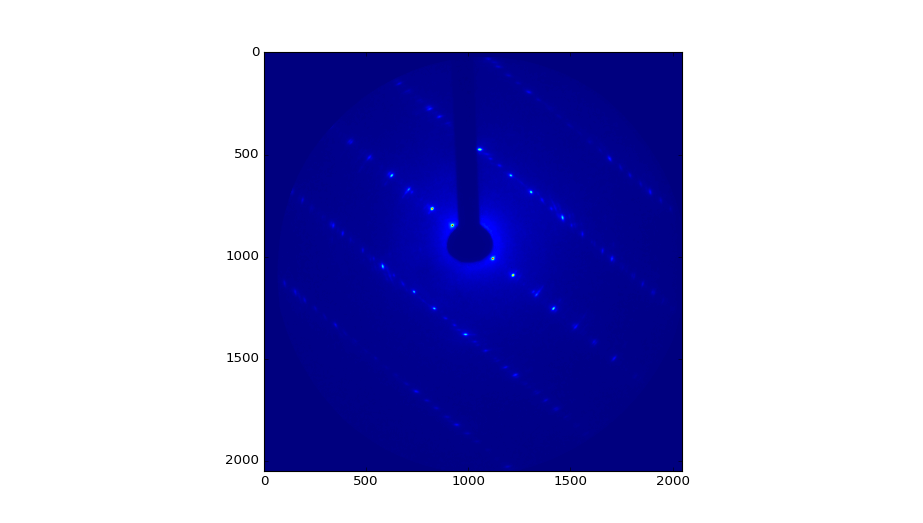

In [8]:
plt.figure()
plt.imshow(d.averaged_data(3))